In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

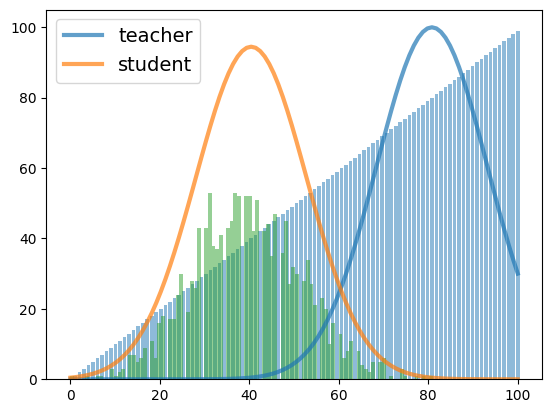

In [94]:
rankings = np.arange(100)
plt.bar(np.linspace(0,1,100) * 100, rankings, alpha=0.5)

teacher_probs = np.exp(-(np.abs(rankings - 80)**2) / 300)
teacher_probs /= teacher_probs.sum()

student_probs = np.exp(-(np.abs(rankings - 40)**2) / 300)
student_probs /= student_probs.sum()

plt.plot(np.linspace(0,1,100) * 100, teacher_probs * 100 / max(teacher_probs), alpha=0.7, linewidth=3, label='teacher')
plt.plot(np.linspace(0,1,100) * 100, student_probs * 100 / max(teacher_probs), alpha=0.7, linewidth=3, label='student')
plt.legend(fontsize=14)

student_samples = np.random.choice(np.arange(100), p=student_probs, size=500000).astype(np.float32)
student_rewards = student_samples.reshape(-1, 2)
student_pairs = student_samples.reshape(-1, 2)
preferences = student_rewards[:, 0] > student_rewards[:, 1]

teacher_samples = np.random.choice(np.arange(100), p=teacher_probs, size=250000).astype(np.float32)

plt.hist(student_samples[:1500], bins=100, alpha=0.5, label='student samples');

In [95]:
device = 'cuda'

In [99]:
pt_true_rewards = torch.arange(100, device=device).detach()
pt_rewards = torch.zeros(100, device=device).requires_grad_()
samples_int = torch.tensor(student_pairs, device=device).long().detach()

optimizer = torch.optim.SGD([pt_rewards], lr=0.01)

n_train_steps = 7500
for idx in range(n_train_steps):
    print(idx, end='\r')
    pred_rewards = pt_rewards[samples_int]
    reward_deltas = pred_rewards[:, 0] - pred_rewards[:, 1]
    true_rewards = pt_true_rewards[samples_int]
    true_reward_deltas = true_rewards[:, 0] - true_rewards[:, 1]
    signs = (true_reward_deltas > 0).float() * 2 - 1
    reward_deltas = reward_deltas * signs
    probs = torch.nn.functional.logsigmoid(reward_deltas)
    loss = -probs.mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [100]:
pt_teacher_samples = torch.tensor(teacher_samples, device=device).long()
pt_sft_policy = torch.zeros(100, device=device).requires_grad_()

sft_optimizer = torch.optim.SGD([pt_sft_policy], lr=0.01)

for idx in range(n_train_steps * 2):
    print(idx, end='\r')
    sft_loss = -torch.nn.functional.log_softmax(pt_sft_policy, dim=0)[pt_teacher_samples].mean()
    sft_loss.backward()
    sft_optimizer.step()
    sft_optimizer.zero_grad()

pt_sft_policy_2x_steps = pt_sft_policy.detach().clone()

/tmp/user/19834/ipykernel_2720798/1444168931.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
/tmp/user/19834/ipykernel_2720798/1444168931.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/tmp/user/19834/ipykernel_2720798/1444168931.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)


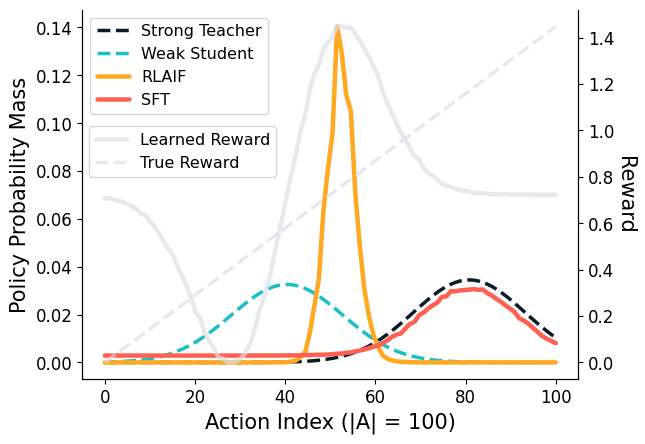

In [101]:
pt_rewards = pt_rewards.cpu()
sft_policy_probs = torch.nn.functional.softmax(pt_sft_policy_2x_steps, dim=0).cpu()

hex_colors = [
    "#FF6150",
    "#134E6F",
    "#1AC0C6",
    "#FFA822",
    "#DEE0E6",
    "#091A29"
]

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax2.plot(np.linspace(0,1,100) * 100, pt_rewards.detach().numpy() - pt_rewards.detach().numpy().min(), linewidth=3.25, label='Learned Reward', c=hex_colors[4], solid_capstyle='round', alpha=0.7)
ax2.plot(np.linspace(0,1,100) * 100, np.linspace(0,1,100) * (pt_rewards.detach().numpy().max() - pt_rewards.detach().numpy().min()), linewidth=2.5, label='True Reward', c=hex_colors[4], solid_capstyle='round', linestyle='--', alpha=0.7)


ax.plot(np.linspace(0,1,100) * 100, teacher_probs, linewidth=2.5, label='Strong Teacher', c=hex_colors[5], linestyle='--', solid_capstyle='round')
ax.plot(np.linspace(0,1,100) * 100, student_probs, linewidth=2.5, label='Weak Student', c=hex_colors[2], linestyle='--', solid_capstyle='round')

beta = 0.1
learned_policy = torch.tensor(student_probs).float() * torch.exp(pt_rewards / beta)
learned_policy /= learned_policy.sum()

ax.plot(np.linspace(0,1,100) * 100, learned_policy.detach().numpy(), linewidth=3.25, label=f'RLAIF', c=hex_colors[3], solid_capstyle='round')

ax.plot(np.linspace(0,1,100) * 100, sft_policy_probs.detach().numpy(), linewidth=3.25, label='SFT', c=hex_colors[0], solid_capstyle='round')

# remove the top and right spines
ax.spines['top'].set_visible(False)

# remove the top and right spines
ax2.spines['top'].set_visible(False)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)

ax.set_xlabel('Action Index (|A| = 100)', fontsize=15)
ax.set_ylabel('Policy Probability Mass', fontsize=15)
ax2.set_ylabel('Reward', fontsize=15, rotation=270, labelpad=15)

ax.legend(fontsize=11.5, loc='upper left')
ax2.legend(fontsize=11.5, bbox_to_anchor=(0.4075, 0.525))
plt.savefig('rlaif.pdf', bbox_inches='tight')